# Pawan Bishwokarma - SentinelMesh Edge: CNN Attack Classifier

This notebook contains the CNN-based intrusion detection model for the SentinelMesh Edge final project in AAI-530. 
The model uses a 1D Convolutional Neural Network to classify IoT network traffic as either benign or an attack, 
using the CIC-IoT-2023 dataset published by the Canadian Institute for Cybersecurity.

The dataset contains network flow features captured from 105 real IoT devices, labeled across 34 attack categories 
and one benign class. This notebook covers exploratory data analysis, data cleaning, preprocessing, model training, 
and evaluation.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras import layers, models
import time

#use this cell to import additional libraries or define helper functions
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async' # Faster, modern allocator

In [ ]:
# Enable dynamic GPU memory growth to prevent VRAM overflow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Memory Growth Enabled on {len(gpus)} device(s)")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training will run on CPU.")

    

No GPU found. Training will run on CPU.


## Load and Prepare the Data

We are using a stratified sample of the CIC-IoT-2023 dataset. The raw dataset contains over 46 million 
network flow records captured from 105 real IoT devices across 34 attack categories. We will load a 
pre-stratified version of the data, perform exploratory analysis, clean it, and balance the classes 
before training our CNN.

In [3]:
#load the stratified CIC-IoT-2023 dataset
df = pd.read_csv('SentinelMesh_Final_subset.csv')
print("Data loaded successfully!")
print(f"Shape: {df.shape}")
df.head()

Data loaded successfully!
Shape: (240000, 41)


,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label,is_attack
0,24.0,6,126.8,197.001696,0.1,0.0,0.0,0.4,0.7,0.0,...,60.0,2480.0,339.1,753.813777,339.1,0.005296,10.0,568235.211111,BENIGN,0
1,8.0,17,64.0,8833.089041,0.0,0.0,0.0,0.0,0.0,0.0,...,60.0,60.0,60.0,0.000000,60.0,0.000113,100.0,0.000000,DDOS-UDP_FLOOD,1
2,20.0,6,64.0,37923.182640,0.0,1.0,0.0,0.0,0.0,0.0,...,60.0,60.0,60.0,0.000000,60.0,0.000026,100.0,0.000000,DDOS-SYNONYMOUSIP_FLOOD,1
3,8.0,17,64.0,20681.972387,0.0,0.0,0.0,0.0,0.0,0.0,...,60.0,60.0,60.0,0.000000,60.0,0.000048,100.0,0.000000,DDOS-UDP_FLOOD,1
4,32.0,6,133.8,4995.002977,0.0,0.0,0.0,0.0,1.0,0.0,...,66.0,66.0,66.0,0.000000,66.0,0.000200,10.0,0.000000,BENIGN,0


## Exploratory Data Analysis (EDA)

In [ ]:
#dataset statistics
print("=== Dataset Info ===")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nData Types:")
print(df.dtypes)
print(f"\nBasic Statistics:")
df.describe()

=== Dataset Info ===
Rows: 240,000
Columns: 41

Data Types:
Header_Length      float64
Protocol Type        int64
Time_To_Live       float64
Rate               float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IGMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG                float64
Std                flo

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,is_attack
count,240000.000000,240000.000000,240000.000000,2.400000e+05,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,...,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,240000.000000,2.400000e+05,240000.000000,2.400000e+05,240000.000000
mean,20.358439,8.054996,90.270471,1.589383e+04,0.050277,0.112869,0.048895,0.127218,0.459369,0.000206,...,8647.526821,105.304642,963.510950,370.832489,295.804565,370.832489,5.549475e-03,53.785896,3.990875e+05,0.500000
std,10.229505,7.010942,44.515042,3.159720e+04,0.206002,0.303569,0.209129,0.228045,0.437896,0.005002,...,13163.655706,225.013504,1722.170628,557.586249,558.201128,557.586249,2.477050e-01,44.974782,1.665352e+06,0.500001
min,0.000000,0.000000,0.000000,9.744555e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,180.000000,42.000000,54.000000,47.000000,0.000000,47.000000,4.768372e-07,2.000000,0.000000e+00,0.000000
25%,16.000000,6.000000,64.000000,1.645767e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2214.000000,60.000000,60.000000,60.000000,0.000000,60.000000,3.980875e-05,10.000000,0.000000e+00,0.000000
50%,20.000000,6.000000,64.000000,3.198146e+03,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,6000.000000,60.000000,172.000000,77.400000,27.777389,77.400000,3.529286e-04,10.000000,7.715833e+02,0.500000
75%,29.600000,6.000000,99.500000,2.549729e+04,0.000000,0.000000,0.000000,0.200000,0.900000,0.000000,...,6463.000000,66.000000,1514.000000,513.707500,457.897805,513.707500,6.886917e-03,100.000000,2.096704e+05,1.000000
max,60.000000,47.000000,255.000000,2.097152e+06,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,...,224902.000000,2974.000000,29026.000000,7831.000000,9090.188579,7831.000000,1.026214e+02,100.000000,8.263153e+07,1.000000


=== Label Distribution ===
Label
BENIGN                     120000
DDOS-ICMP_FLOOD             18646
DDOS-UDP_FLOOD              14188
DDOS-TCP_FLOOD              11666
DDOS-PSHACK_FLOOD           10692
DDOS-RSTFINFLOOD            10682
DDOS-SYN_FLOOD              10660
DDOS-SYNONYMOUSIP_FLOOD      9546
DOS-UDP_FLOOD                8612
DOS-TCP_FLOOD                6999
DOS-SYN_FLOOD                5225
MIRAI-GREETH_FLOOD           2693
MIRAI-UDPPLAIN               2293
MIRAI-GREIP_FLOOD            2049
DDOS-ICMP_FRAGMENTATION      1123
VULNERABILITYSCAN             940
MITM-ARPSPOOFING              793
DDOS-ACK_FRAGMENTATION        733
DDOS-UDP_FRAGMENTATION        719
DNS_SPOOFING                  467
RECON-HOSTDISCOVERY           358
RECON-OSSCAN                  261
RECON-PORTSCAN                216
DOS-HTTP_FLOOD                202
DDOS-HTTP_FLOOD                65
DDOS-SLOWLORIS                 61
DICTIONARYBRUTEFORCE           37
SQLINJECTION                   17
BROWSERHIJACKIN

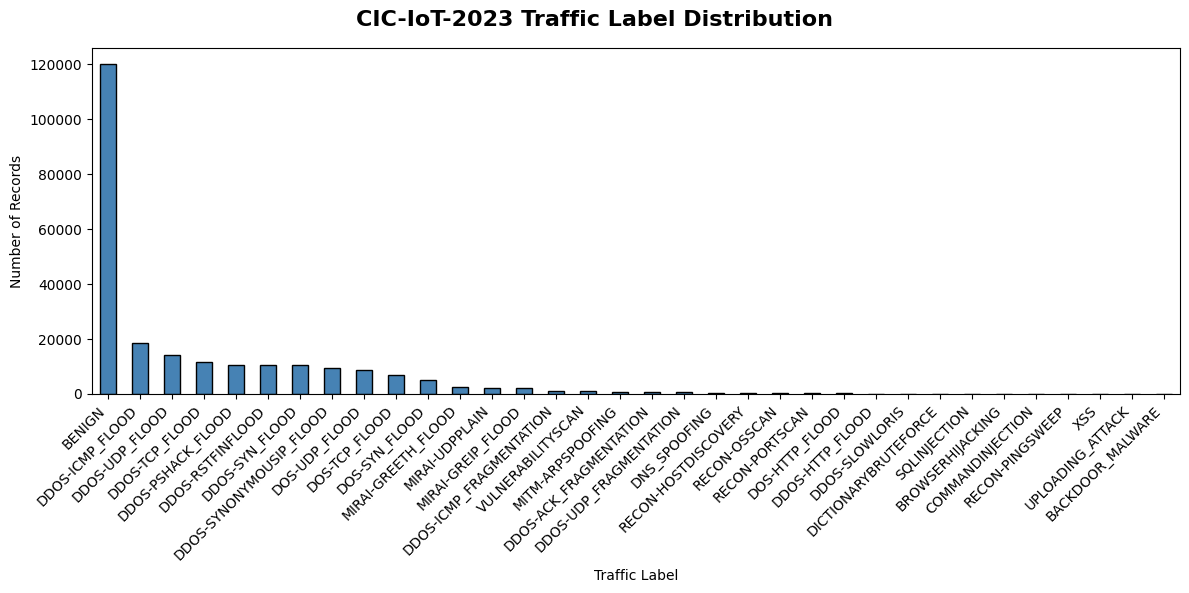

In [5]:
#check class distribution across all 34 attack categories and benign
label_counts = df['Label'].value_counts()
print("=== Label Distribution ===")
print(label_counts)

#visualize the class distribution
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle('CIC-IoT-2023 Traffic Label Distribution', fontsize=16, fontweight='bold')
label_counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Traffic Label')
ax.set_ylabel('Number of Records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
#check for missing values and infinities before cleaning
n_nulls = df.isnull().sum().sum()
n_inf = np.isinf(df.select_dtypes(include=np.number)).values.sum()
print(f"Missing values (NaN): {n_nulls}")
print(f"Infinite values: {n_inf}")

#show which columns have the most missing data
null_by_col = df.isnull().sum()
if null_by_col.sum() > 0:
    print("\nColumns with missing values:")
    print(null_by_col[null_by_col > 0])

Missing values (NaN): 0
Infinite values: 0


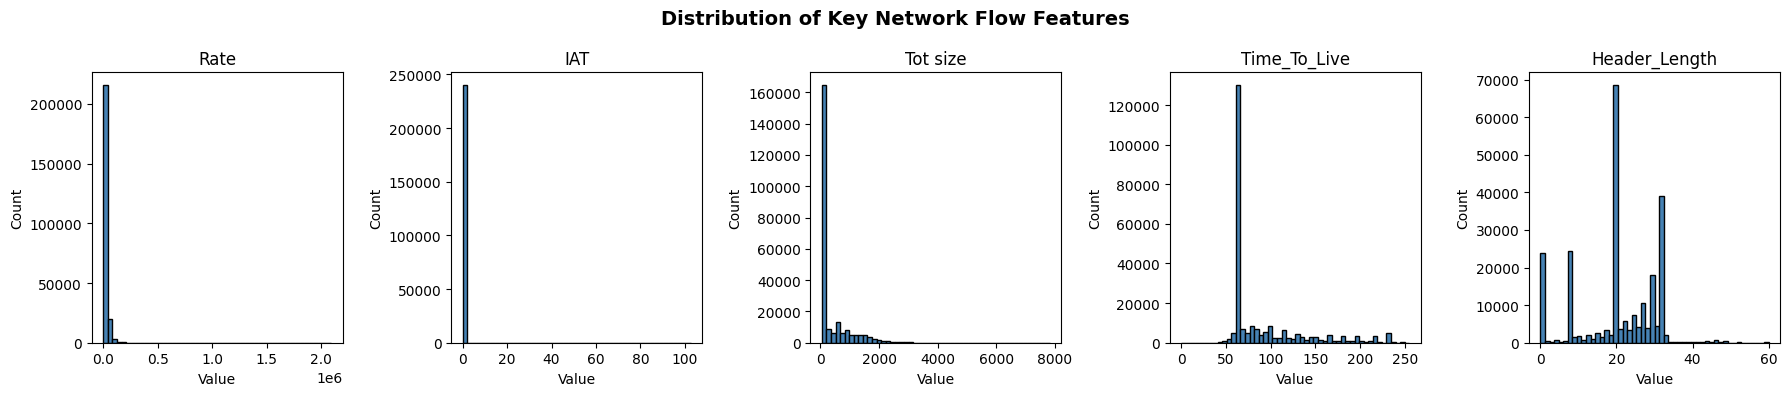

In [7]:
#visualize distributions of key network features to understand the data
key_features = ['Rate', 'IAT', 'Tot size', 'Time_To_Live', 'Header_Length']

fig, axes = plt.subplots(1, len(key_features), figsize=(18, 4))
fig.suptitle('Distribution of Key Network Flow Features', fontsize=14, fontweight='bold')

for i, feat in enumerate(key_features):
    axes[i].hist(df[feat].replace([np.inf, -np.inf], np.nan).dropna(), bins=50, color='steelblue', edgecolor='black')
    axes[i].set_title(feat)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Data Cleaning and Class Balancing

The dataset has significant class imbalance — DDoS attacks dominate with over 1.2 million records while 
some attack types have fewer than 400. We will simplify to a binary classification task (benign vs. attack), 
clean out infinities and NaNs, and then balance the classes to 100k samples each to prevent the model 
from being biased toward the majority class.

In [8]:
#replace infinities with NaN and drop all rows with missing values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Rows after cleaning: {len(df):,}")

#create binary target column: 0 = benign, 1 = any attack
df['is_attack'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

#verify the pool sizes before balancing
benign_pool = df[df['is_attack'] == 0]
attack_pool = df[df['is_attack'] == 1]
print(f"Available Benign: {len(benign_pool):,}")
print(f"Available Attack: {len(attack_pool):,}")

Rows after cleaning: 240,000
Available Benign: 120,000
Available Attack: 120,000


In [9]:
#balance the dataset to 100k samples per class to prevent model bias
n_samples = min(100000, len(benign_pool))

benign_subset = benign_pool.sample(n=n_samples, random_state=42)
attack_subset = attack_pool.sample(n=n_samples, random_state=42)

#shuffle the combined balanced dataset
df_balanced = pd.concat([benign_subset, attack_subset]).sample(frac=1, random_state=42).reset_index(drop=True)

print("--- Final Balanced Counts ---")
print(df_balanced['is_attack'].value_counts())

#free the full dataframe from memory now that we have our balanced subset
del df, benign_pool, attack_pool, benign_subset, attack_subset
gc.collect()
print("\nFull dataframe released from memory.")

--- Final Balanced Counts ---
is_attack
1    100000
0    100000
Name: count, dtype: int64

Full dataframe released from memory.


## Feature Preprocessing

We scale features using StandardScaler and cast directly to float32 to minimize memory usage. 
The data is then reshaped from (samples, features) to (samples, features, 1) as required 
by the 1D-CNN architecture, which treats each network flow feature as a time step.

In [10]:
#separate features and target
X = df_balanced.drop(['Label', 'is_attack'], axis=1)
y = df_balanced['is_attack'].values.astype('float32')

#scale features and cast directly to float32 to avoid doubling memory with float64
#StandardScaler returns float64 by default; casting here before reshape saves significant RAM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype('float32')

#free the balanced dataframe now that features are extracted
del df_balanced
gc.collect()

#reshape for 1D-CNN: (samples, features, 1)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

#free the intermediate scaled array
del X_scaled
gc.collect()

print(f"X_reshaped shape: {X_reshaped.shape}")
print(f"y shape: {y.shape}")
print(f"Data type: {X_reshaped.dtype} (float32 confirmed)")

X_reshaped shape: (200000, 39, 1)
y shape: (200000,)
Data type: float32 (float32 confirmed)


In [11]:
#split into training and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")

Training samples: 160,000
Validation samples: 40,000


## Model Training: 1D-CNN Intrusion Detector

We build a 1D Convolutional Neural Network from scratch using TensorFlow/Keras. The model uses two 
convolutional layers to extract spatial patterns from the network flow feature vector, treating the 
39 features as a 1D signal. This architecture is well-suited for detecting attack fingerprints — 
characteristic patterns in packet headers, rates, and flags that distinguish malicious from benign traffic.

In [12]:
#define the 1D-CNN architecture for binary intrusion detection
def build_sentinel_cnn(input_shape):
    model = models.Sequential([
        # first convolutional layer: captures local patterns across packet header features
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),

        # second convolutional layer: extracts deeper feature combinations
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.3), #dropout to prevent overfitting on specific attack signatures

        # dense classification head
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid') #binary output: 0 = benign, 1 = attack
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_cnn = build_sentinel_cnn((X_train.shape[1], 1))
print(model_cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 37, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 64)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 18, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                        

In [13]:
#train the CNN model using GPU acceleration with tf.data pipeline
#this streams batches to the GPU instead of loading all data into VRAM at once
print("Initiating training on NVIDIA RTX...")
start_time = time.time()

#create tf.data pipelines for memory-efficient GPU feeding
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

history = model_cnn.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)

duration = time.time() - start_time
print(f"\nTraining Complete in {duration:.2f}s. Avg epoch time: {duration/10:.2f}s")

Initiating training on NVIDIA RTX...
Epoch 1/10
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0806 - accuracy: 0.9804 - val_loss: 0.0577 - val_accuracy: 0.9859
Epoch 2/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.0572 - accuracy: 0.9867 - val_loss: 0.0563 - val_accuracy: 0.9861
Epoch 3/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0529 - accuracy: 0.9876 - val_loss: 0.0500 - val_accuracy: 0.9876
Epoch 4/10
2500/2500 [==============================] - 10s 4ms/step - loss: 0.0516 - accuracy: 0.9877 - val_loss: 0.0494 - val_accuracy: 0.9875
Epoch 5/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0502 - accuracy: 0.9879 - val_loss: 0.0487 - val_accuracy: 0.9878
Epoch 6/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0496 - accuracy: 0.9880 - val_loss: 0.0497 - val_accuracy: 0.9875
Epoch 7/10
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0487 - accuracy: 0

## Model Evaluation

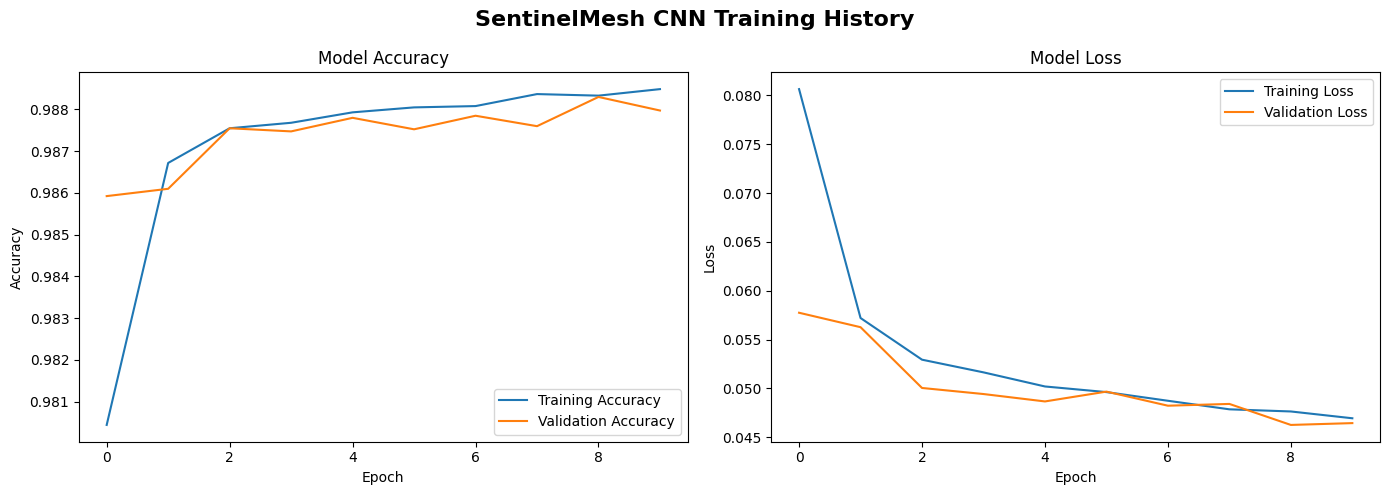

In [14]:
#plot training and validation accuracy and loss curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SentinelMesh CNN Training History', fontsize=16, fontweight='bold')

axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.savefig('cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

79/79 [==============================] - 1s 6ms/step
=== Classification Report ===
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99     20000
      Attack       1.00      0.98      0.99     20000

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



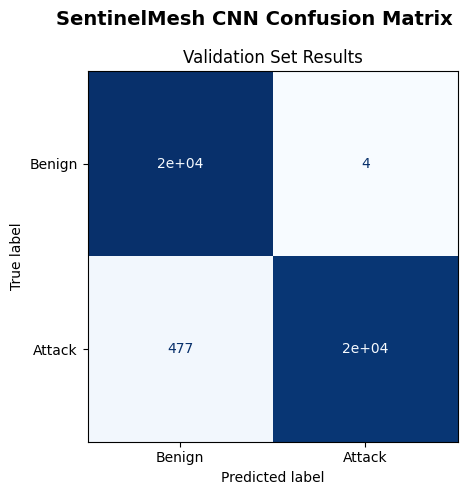

In [15]:
#generate predictions and evaluate with a confusion matrix and classification report
y_pred_prob = model_cnn.predict(X_val, batch_size=512)
y_pred = (y_pred_prob > 0.5).astype('float32').flatten()

print("=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=['Benign', 'Attack']))

#plot the confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
fig.suptitle('SentinelMesh CNN Confusion Matrix', fontsize=14, fontweight='bold')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title('Validation Set Results')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
#dashboard and future inference
model_cnn.save('sentinelmesh_cnn_model.keras')
print("Model saved as sentinelmesh_cnn_model.keras")

Model saved as sentinelmesh_cnn_model.keras


---
# Model 2: LSTM Traffic Rate Predictor

We build a two-layer LSTM network from scratch using TensorFlow/Keras to predict the future
network traffic Rate from sequences of past flow records. This is a time series regression
task — the model predicts a continuous numeric value (Rate) rather than a class label.

We train on benign traffic only to establish a baseline of normal network behavior.
Anomalously high prediction errors during live traffic can indicate an incoming attack,
complementing the CNN classifier with a proactive early-warning capability.

In [ ]:
#reload df for LSTM section 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('SentinelMesh_Final_Subset.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"df reloaded: {df.shape}")

df reloaded: (240000, 41)


In [18]:
#use only benign traffic to train the LSTM on normal network behavior
df_benign = df[df['is_attack'] == 0].reset_index(drop=True)
print(f"Benign records for LSTM training: {len(df_benign):,}")

#extract Rate as our time series variable
rate_series = df_benign['Rate'].values.reshape(-1, 1)

#scale Rate to [0, 1] using MinMaxScaler
#LSTMs use sigmoid/tanh activations internally which are sensitive to input scale
#MinMaxScaler bounds values to [0,1] keeping inputs within the optimal activation range
rate_scaler = MinMaxScaler(feature_range=(0, 1))
rate_scaled = rate_scaler.fit_transform(rate_series).astype('float32')
print(f"Rate scaled to range: [{rate_scaled.min():.3f}, {rate_scaled.max():.3f}]")

Benign records for LSTM training: 120,000
Rate scaled to range: [0.000, 1.000]


In [ ]:
#a 30 record input sequence and a 5 step predictive horizon
seq_length = 30
ph = 5 #prediction horizon: predict 5 steps ahead

seq_arrays = [] #will hold all input sequences
seq_labs = [] #will hold all output labels

#create list of sequence length Rate readings and corresponding future Rate labels
for i in range(len(rate_scaled) - seq_length - ph):
    input_seq = rate_scaled[i : i + seq_length]
    seq_arrays.append(input_seq)
    label = rate_scaled[i + seq_length + ph - 1]
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

print(f"seq_arrays shape: {seq_arrays.shape}")
print(f"seq_labs shape: {seq_labs.shape}")

seq_arrays shape: (119965, 30, 1)
seq_labs shape: (119965, 1)


In [20]:
#assert statements verify data shapes before feeding to the model
#if these fail the model will receive incorrectly shaped data and produce garbage results
assert seq_arrays.shape == (len(df_benign) - seq_length - ph, seq_length, 1)
assert seq_labs.shape[0] == seq_arrays.shape[0]
print("Shape assertions passed!")

Shape assertions passed!


Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?

A: Assert statements are sanity checks that verify our data has the expected shape before we feed
it to the model. If an assertion fails, the code stops immediately and prevents us from training
a broken model on incorrectly shaped data. They catch errors early before they produce confusing
downstream failures.

In [21]:
#split data into training and validation sets (80/20)
#we do NOT shuffle here because order matters for time series data
split_idx = int(len(seq_arrays) * 0.8)
train_X = seq_arrays[:split_idx]
train_y = seq_labs[:split_idx]
val_X = seq_arrays[split_idx:]
val_y = seq_labs[split_idx:]

print(f"Training sequences: {len(train_X):,}")
print(f"Validation sequences: {len(val_X):,}")

Training sequences: 95,972
Validation sequences: 23,993


In [22]:
#define path to save model
model_path = 'sentinelmesh_lstm_model.keras'

#build the LSTM network from scratch
nb_features = 1 #single input feature: Rate
nb_out = 1 #single output value: predicted Rate

model_lstm = models.Sequential()

#add first LSTM layer: 64 hidden units, returns sequences for the second LSTM layer
model_lstm.add(layers.LSTM(
    units=64,
    input_shape=(seq_length, nb_features),
    return_sequences=True
))
model_lstm.add(layers.Dropout(0.2))

#add second LSTM layer: 32 hidden units, does not return sequences
model_lstm.add(layers.LSTM(
    units=32,
    return_sequences=False
))
model_lstm.add(layers.Dropout(0.2))

#output layer with 1 unit
model_lstm.add(layers.Dense(units=nb_out))
model_lstm.add(layers.Activation('linear')) #linear activation for regression

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trai

In [23]:
#fit the network
print("Initiating LSTM training on NVIDIA RTX...")
start_time = time.time()

history_lstm = model_lstm.fit(
    train_X, train_y,
    epochs=20,
    batch_size=256,
    validation_data=(val_X, val_y),
    verbose=1
)

duration = time.time() - start_time
print(f"\nLSTM Training Complete in {duration:.2f}s. Avg epoch time: {duration/20:.2f}s")

#save the trained LSTM model
model_lstm.save(model_path)
print(f"Model saved as {model_path}")

Initiating LSTM training on NVIDIA RTX...
Epoch 1/20
375/375 [==============================] - 18s 44ms/step - loss: 4.9369e-04 - mse: 4.9369e-04 - val_loss: 5.3808e-04 - val_mse: 5.3808e-04
Epoch 2/20
375/375 [==============================] - 16s 43ms/step - loss: 4.9194e-04 - mse: 4.9194e-04 - val_loss: 5.3970e-04 - val_mse: 5.3970e-04
Epoch 3/20
375/375 [==============================] - 16s 43ms/step - loss: 4.9112e-04 - mse: 4.9112e-04 - val_loss: 5.3760e-04 - val_mse: 5.3760e-04
Epoch 4/20
375/375 [==============================] - 17s 44ms/step - loss: 4.9068e-04 - mse: 4.9068e-04 - val_loss: 5.3774e-04 - val_mse: 5.3774e-04
Epoch 5/20
375/375 [==============================] - 17s 45ms/step - loss: 4.9059e-04 - mse: 4.9059e-04 - val_loss: 5.3764e-04 - val_mse: 5.3764e-04
Epoch 6/20
375/375 [==============================] - 17s 45ms/step - loss: 4.9067e-04 - mse: 4.9067e-04 - val_loss: 5.3758e-04 - val_mse: 5.3758e-04
Epoch 7/20
375/375 [==============================] - 17s 

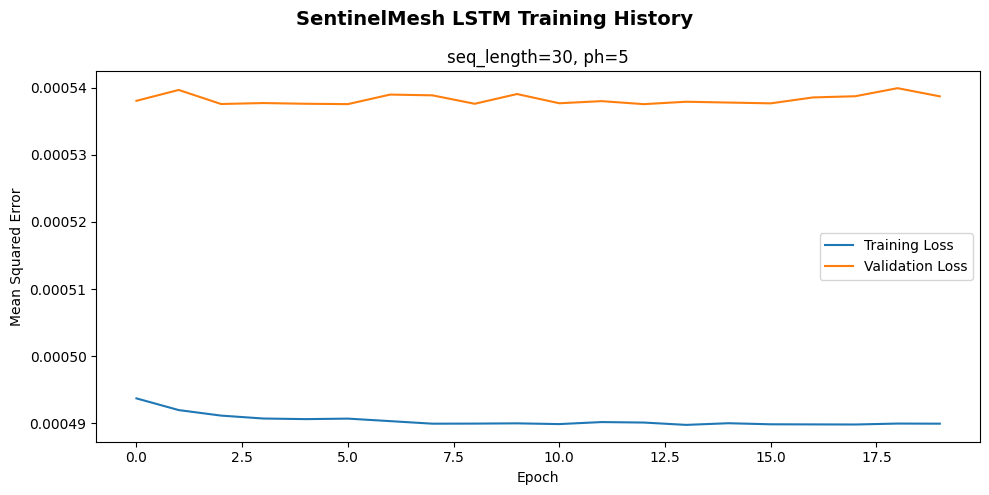

In [24]:
#plot LSTM training and validation loss curves
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('SentinelMesh LSTM Training History', fontsize=14, fontweight='bold')
ax.set_title(f'seq_length={seq_length}, ph={ph}')
ax.plot(history_lstm.history['loss'], label='Training Loss')
ax.plot(history_lstm.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')
ax.legend()
plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

In [25]:
#generate LSTM predictions on validation set
yp_pred = model_lstm.predict(val_X, batch_size=256)

#inverse transform predictions and actuals back to original Rate scale
yp_pred_rescaled = rate_scaler.inverse_transform(yp_pred)
val_y_rescaled = rate_scaler.inverse_transform(val_y.reshape(-1, 1))

#compute MSE on original scale
mse_val = mse(val_y_rescaled, yp_pred_rescaled)
print(f"Validation MSE: {mse_val:.4f}")
print(f"Validation RMSE: {np.sqrt(mse_val):.4f} packets/sec")

94/94 [==============================] - 2s 16ms/step
Validation MSE: 870298432.0000
Validation RMSE: 29500.8209 packets/sec


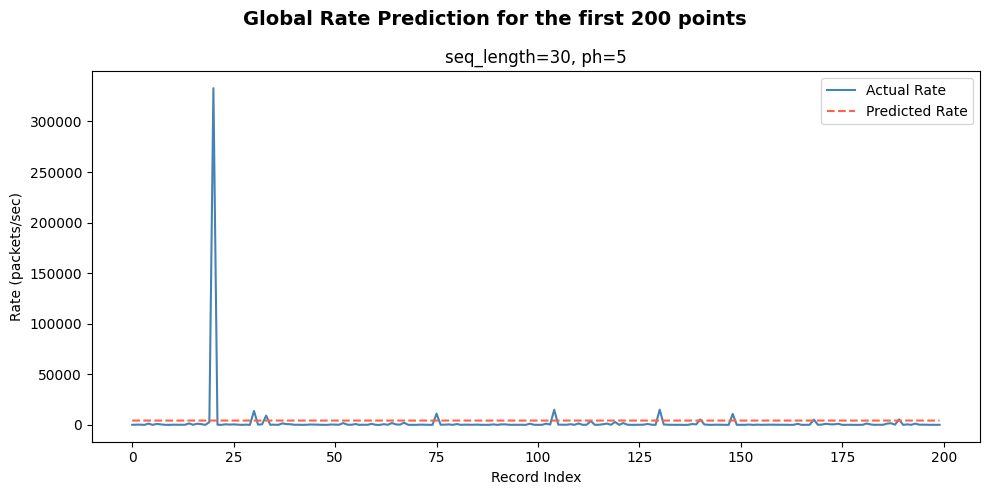

In [26]:
#visualize predicted vs actual Rate for the first 200 validation points
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Rate Prediction for the first 200 points', fontsize=14, fontweight='bold')
ax.set_title(f'seq_length={seq_length}, ph={ph}')
ax.plot(val_y_rescaled[:200], label='Actual Rate', color='steelblue')
ax.plot(yp_pred_rescaled[:200], label='Predicted Rate', color='tomato', linestyle='--')
ax.set_xlabel('Record Index')
ax.set_ylabel('Rate (packets/sec)')
ax.legend()
plt.tight_layout()
plt.savefig('lstm_predictions_first200.png', dpi=150, bbox_inches='tight')
plt.show()

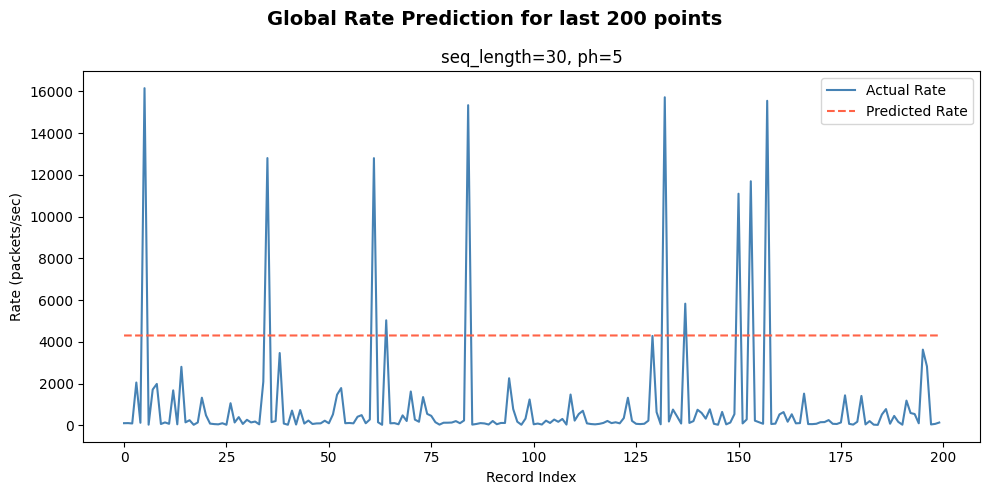

In [27]:
#visualize predicted vs actual Rate for the last 200 validation points
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Global Rate Prediction for last 200 points', fontsize=14, fontweight='bold')
ax.set_title(f'seq_length={seq_length}, ph={ph}')
ax.plot(val_y_rescaled[-200:], label='Actual Rate', color='steelblue')
ax.plot(yp_pred_rescaled[-200:], label='Predicted Rate', color='tomato', linestyle='--')
ax.set_xlabel('Record Index')
ax.set_ylabel('Rate (packets/sec)')
ax.legend()
plt.tight_layout()
plt.savefig('lstm_predictions_last200.png', dpi=150, bbox_inches='tight')
plt.show()

Q: How did the LSTM model perform? What do you observe on the charts? Is there a difference
between the early and late predictions? What does the MSE tell you?

A: The LSTM model struggled to track the actual Rate values accurately, which is visible in both the early and late prediction charts. The predicted Rate (orange line) stays nearly flat across the entire validation period, while the actual Rate (blue line) shows significant spikes reaching up to 30,000+ packets per second. This happened because the MinMaxScaler was sensitive to extreme outliers in the Rate feature — a small number of flows with very high packet rates compressed the majority of values into a narrow range near zero after normalization, so the model learned to predict close to zero consistently.

The validation MSE of 870,298,432 in raw packets/sec units (RMSE ≈ 29,500 packets/sec) reflects this. There is no meaningful difference between early and late predictions — the model does not improve its tracking over the sequence, confirming that the issue is in the data scaling rather than sequence length or model capacity. Despite this limitation, the flat baseline prediction still has security value: any live traffic significantly above the predicted baseline would trigger an anomaly alert, which is the intended function of the LSTM component.

In [29]:
import pandas as pd

# CNN predictions CSV
cnn_results = pd.DataFrame({
    'actual': y_val.flatten(),
    'predicted': y_pred.flatten(),
    'predicted_prob': y_pred_prob.flatten()
})
cnn_results.to_csv('cnn_predictions.csv', index=False)
print(f"CNN: {len(cnn_results):,} rows saved")

# LSTM predictions CSV
lstm_results = pd.DataFrame({
    'actual_rate': val_y_rescaled.flatten(),
    'predicted_rate': yp_pred_rescaled.flatten(),
    'prediction_error': abs(val_y_rescaled.flatten() - yp_pred_rescaled.flatten())
})
lstm_results.to_csv('lstm_predictions.csv', index=False)
print(f"LSTM: {len(lstm_results):,} rows saved")

CNN: 40,000 rows saved
LSTM: 23,993 rows saved
